### IMEC2543 - DINAMICA DE MAQUINARIA
### [Luis Alejandro Rodríguez Arenas](https://luigitoby.github.io/) Cod. 202321287
### Experiencia 1 - Cinética Directa e Inversa

In [1]:
import numpy as np
from numpy import deg2rad
from sympy import symbols, pi, sin, cos, lambdify, solve
from sympy.physics.mechanics import ReferenceFrame, dynamicsymbols
from scipy import optimize
from scipy.optimize import fsolve
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Dinámica directa
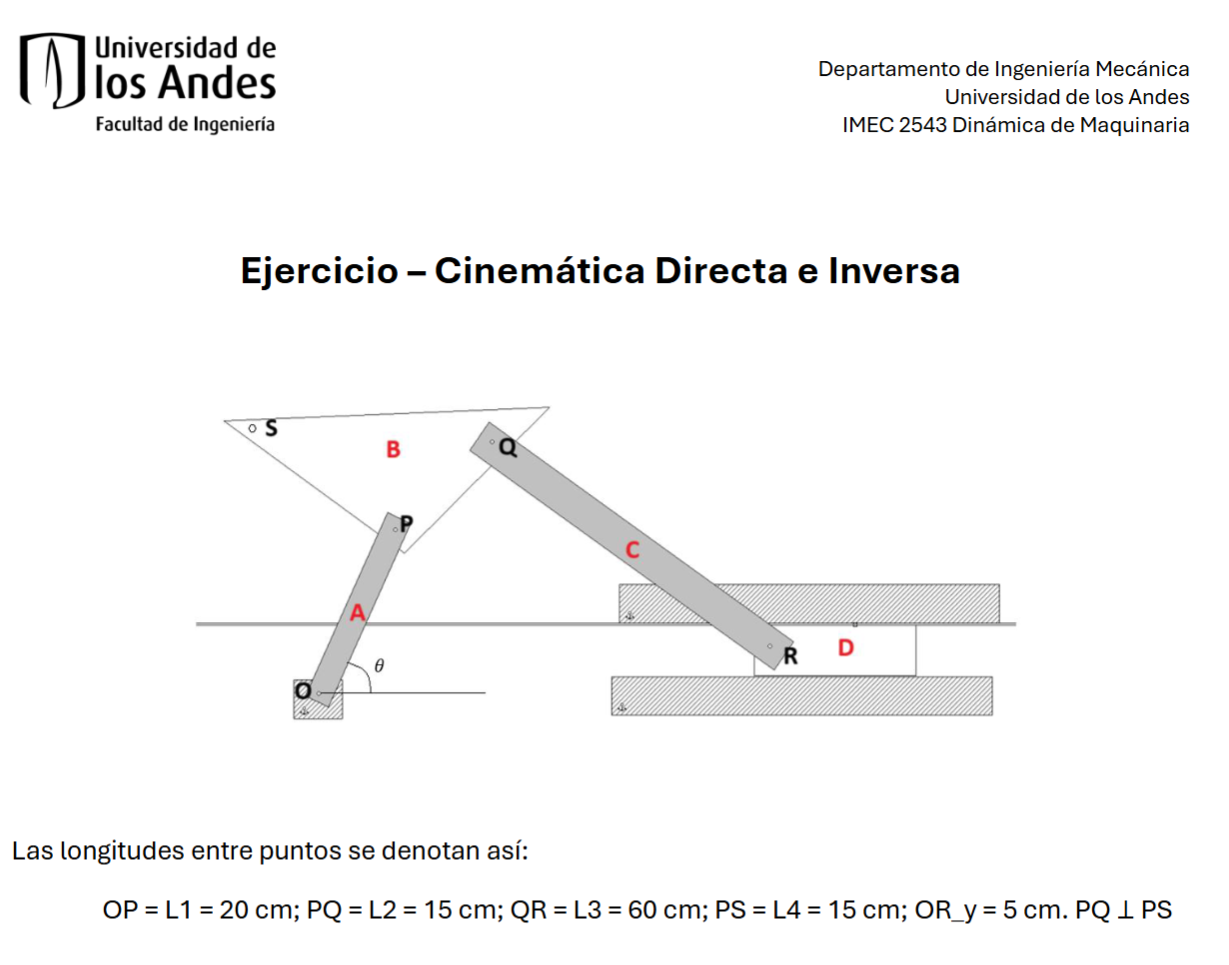

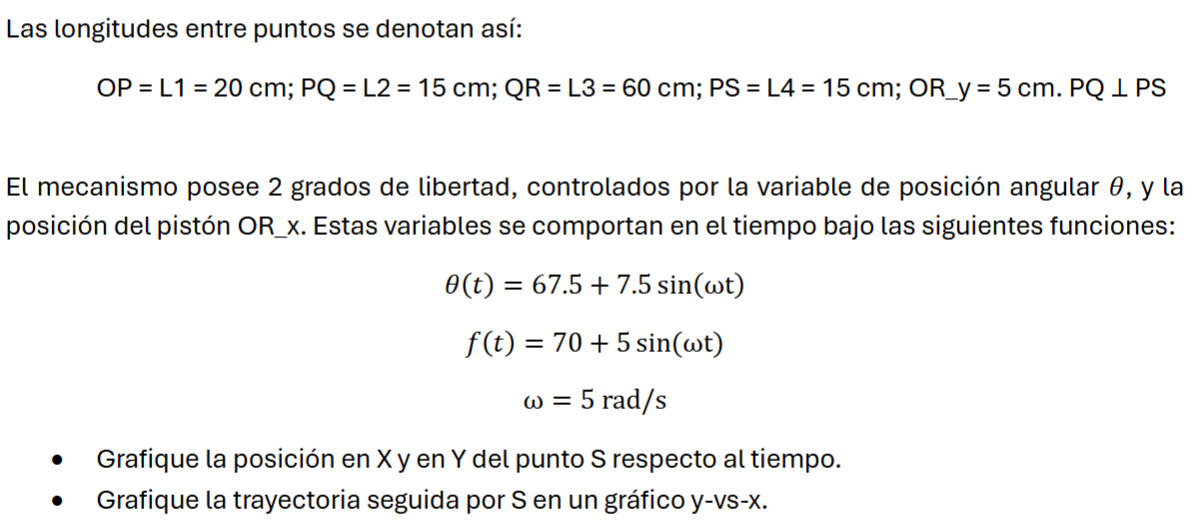

### Cálculo de grados de llibertad

Podemos calcular los grados de libertad usando la siguiente formula Gruebler's equation:
$$M_{DOF}=3L-2J-3G$$
* Donde $L$ son los cuerpos, $J$ número de uniones y $G$ el número de grounded links
Note que como solo hay un ground, $G=1$

* Ahora esto se puede simplificar usando la modificación de Kutzbach's, la ecuación queda como
$$M=3(L-1)-2J_1-J_2$$
* Donde
    * $M$ son los DOF
    * $L$ número de cuerpos
    * $J_1$ número de uniones (1DOF)
    * $J_2$ número de medias uniones (2DOF)

Luego esta forma se puede simplificar aún más escribiendola así
$$M=3(L)-2(J)$$
* Pero entonces las uniones son equivalentes a 1 mientras que al sumar las medias uniones, aquellas que permiten mantener dos grados de libertad, estas suman **0.5** solamente.
* Teniendo en cuenta lo anterior remplazando en nuestra ecuación podemos determinar los grados de libertad del mecanismo, en este caso son:
$$M=3(3)-2(3+0.5)=2 DOF$$
* Note que tiene 3 cuerpos, 3 revolutas (3 joints con 1 DOF) y 1 joint con 2DOF, que es el slider, pues pemite movimiento en x y rotación, por esto es que se suma 0.5.

# Diagrama con marcos de referencia y nomenclatura

# Cinemática Directa
La cinemática directa consiste en calcular el movimiento de un mecanismo a partir de las variables de entrada conocidas, sin considerar fuerzas ni momentos.

In [2]:
# Simbolos
L1, L2, L3, L4, OR_y, omega, t = symbols('L1 L2 L3 L4 OR_y omega t') 
# Simbolos dinámicos
theta1, theta2, theta3, OR_x = dynamicsymbols('theta1 theta2 theta3 OR_x')
N = ReferenceFrame('N')
A = N.orientnew('A', 'Axis', [theta1, N.z])
B = A.orientnew('B', 'Axis', [-theta2, N.z])
C = B.orientnew('C', 'Axis', [-theta3, N.z])

params={L1:0.2,L2:0.15,L3:0.6,L4:0.15,OR_y:0.05}

r1 = L1*A.x
r2 = L2*B.x
r3 = L3*C.x
r4 = -OR_y*N.y - OR_x*N.x

# Mismo loop que el ejemplo de las 4 barras pero en este caso cerramos con un vector constante y el slider
eqLoop = r1 + r2 + r3 + r4

# Expresamos todo en N
eqParams = eqLoop.subs(params)

eq_fun = lambdify(
    [theta1, theta2, theta3, OR_x],
    [eqParams.dot(N.x), eqParams.dot(N.y)]
)

display(eqLoop)
display(eqParams)
display([eqParams.dot(N.x), eqParams.dot(N.y)])

- OR_x(t)*N.x - OR_y*N.y + L1*A.x + L2*B.x + L3*C.x

- OR_x(t)*N.x - 0.05*N.y + 0.2*A.x + 0.15*B.x + 0.6*C.x

[0.6*(sin(theta1(t))*sin(theta2(t)) + cos(theta1(t))*cos(theta2(t)))*cos(theta3(t)) - 0.6*(-sin(theta1(t))*cos(theta2(t)) + sin(theta2(t))*cos(theta1(t)))*sin(theta3(t)) - OR_x(t) + 0.15*sin(theta1(t))*sin(theta2(t)) + 0.15*cos(theta1(t))*cos(theta2(t)) + 0.2*cos(theta1(t)),
 -0.6*(sin(theta1(t))*sin(theta2(t)) + cos(theta1(t))*cos(theta2(t)))*sin(theta3(t)) + 0.6*(sin(theta1(t))*cos(theta2(t)) - sin(theta2(t))*cos(theta1(t)))*cos(theta3(t)) + 0.15*sin(theta1(t))*cos(theta2(t)) + 0.2*sin(theta1(t)) - 0.15*sin(theta2(t))*cos(theta1(t)) - 0.05]

### Código para plotear el mecanismo, este si fue ~~robado~~ pedido prestado de Jonathan

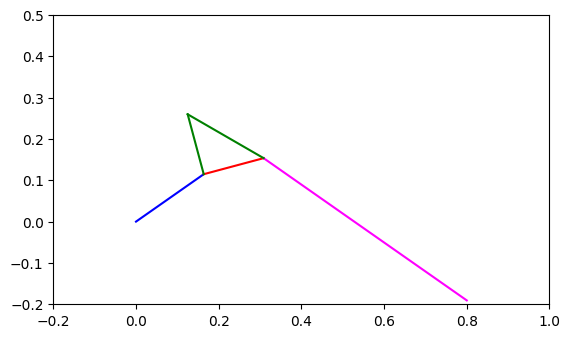

In [3]:
points={'O':0*N.x,'P':r1,'Q':r1+r2,'R':r1+r2+r3,'S':r1+L4*B.y}
points_fun={k:lambdify([theta1,theta2,theta3,OR_x],[v.dot(N.x).subs(params),v.dot(N.y).subs(params)]) for k,v in points.items()}
# Esta función de aquí se ve complicada, pero en realidad es bastante bonita, entonces esta función
# se encarga de crear un diccionario de funciones numéricas para cada punto del mecanismo
# Cada función recibe los ángulos y la posición x de OR y devuelve las coordenadas x e y del punto correspondiente

def plotMechanism(joint_values,ax=None):    
    O=points_fun['O'](*joint_values) # Operador de unpacking, es decir, toma la lista de joint_values y los pasa como argumentos a la función de cada punto
    P=points_fun['P'](*joint_values)
    Q=points_fun['Q'](*joint_values)
    R=points_fun['R'](*joint_values)
    S=points_fun['S'](*joint_values)
    if ax is None:
        ax=plt.figure().add_subplot(111)
    ax.plot([O[0],P[0]], [O[1],P[1]], 'BLUE')
    ax.plot([P[0],Q[0]], [P[1],Q[1]], 'red')
    ax.plot([Q[0],R[0]], [Q[1],R[1]], 'magenta')
    ax.plot([P[0],S[0]], [P[1],S[1]], 'green')
    ax.plot([Q[0],S[0]], [Q[1],S[1]], 'green')
    ax.set_aspect('equal')
    ax.set_xlim(-0.2,1.0)
    ax.set_ylim(-0.2,0.5)

# Example with some arbitrary joint values

plotMechanism([np.deg2rad(35),np.deg2rad(20),np.deg2rad(50),2])


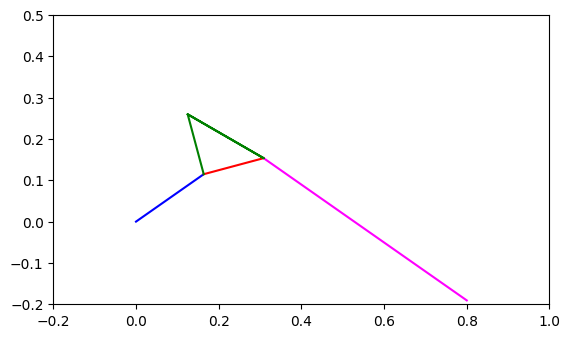

In [4]:
# También se puede definir de esta manera, solo quería mirar como funcionaba el ax.plot

def plotMechanism(joint_values,ax=None):    
    O=points_fun['O'](*joint_values) # Operador de unpacking, es decir, toma la lista de joint_values y los pasa como argumentos a la función de cada punto
    P=points_fun['P'](*joint_values)
    Q=points_fun['Q'](*joint_values)
    R=points_fun['R'](*joint_values)
    S=points_fun['S'](*joint_values)
    if ax is None:
        ax=plt.figure().add_subplot(111)
    ax.plot([O[0],P[0]], [O[1],P[1]], 'BLUE')
    ax.plot([P[0],Q[0]], [P[1],Q[1]], 'red')
    ax.plot([Q[0],R[0]], [Q[1],R[1]], 'magenta')
    ax.plot([P[0],S[0], Q[0],S[0]], [P[1],S[1], Q[1],S[1]], 'green')
    # ax.plot([Q[0],S[0]], [Q[1],S[1]], 'green')
    ax.set_aspect('equal')
    ax.set_xlim(-0.2,1.0)
    ax.set_ylim(-0.2,0.5)
    
plotMechanism([np.deg2rad(35),np.deg2rad(20),np.deg2rad(50),2])


#### Sidequest para buscar los puntos iniciales con sentido, de theta1 y OR_x

In [5]:
# Funciones dadas
theta = 67.5 + 7.5*sin(omega*t)      # grados
f = 70 + 5*sin(omega*t)              # cm

# Valor de omega
omega_val = 5

In [6]:
# Funciones numéricas
theta_fun = lambdify(t, theta.subs(omega, omega_val), 'numpy')
f_fun = lambdify(t, f.subs(omega, omega_val), 'numpy')


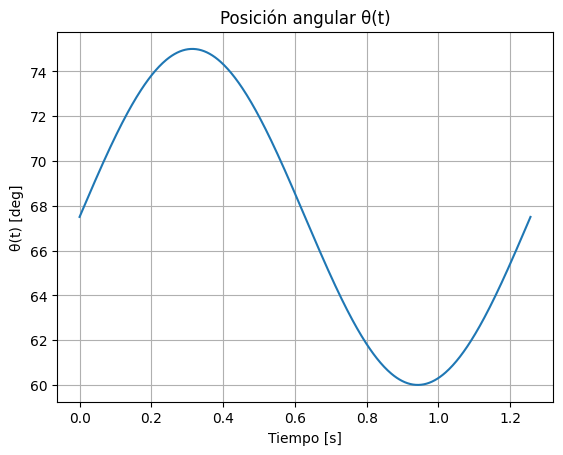

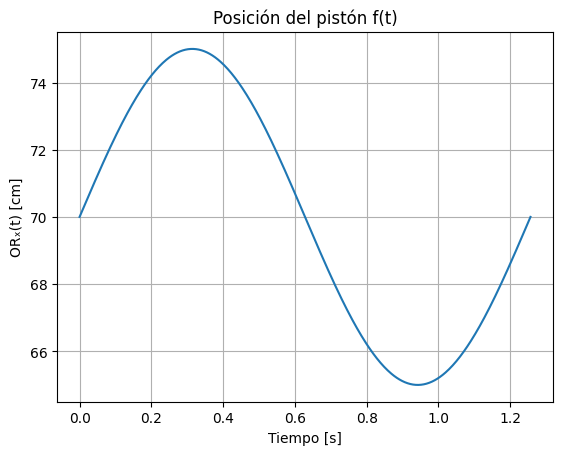

In [7]:
# Vector de tiempo
T = 2*np.pi/omega_val
t_vals = np.linspace(0, T, 500)

theta_vals = theta_fun(t_vals)
f_vals = f_fun(t_vals)

# Gráficas
plt.figure()
plt.plot(t_vals, theta_vals)
plt.xlabel('Tiempo [s]')
plt.ylabel('θ(t) [deg]')
plt.title('Posición angular θ(t)')
plt.grid()

plt.figure()
plt.plot(t_vals, f_vals)
plt.xlabel('Tiempo [s]')
plt.ylabel('ORₓ(t) [cm]')
plt.title('Posición del pistón f(t)')
plt.grid()

plt.show()


In [8]:
theta_0 = theta.subs({t:0})
f_0 = f.subs({t:0})

theta_0, f_0


(67.5000000000000, 70)

### Ahora si cinemática directa
Primero hacemos UN CASO de la cinemática directa y luego hacemos el loop para barrer todos los valores

(array([-0.72423413,  1.92322473]),
 {'nfev': 15,
  'fjac': array([[-0.16151229, -0.9868707 ],
         [ 0.9868707 , -0.16151229]]),
  'r': array([ 0.56566552,  0.58749827, -0.14930757]),
  'qtf': array([ 1.52588784e-12, -1.04510232e-16]),
  'fvec': array([5.55111512e-17, 9.85322934e-16])},
 1,
 'The solution converged.')

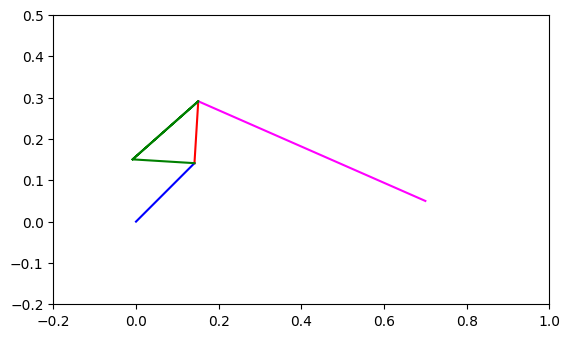

In [9]:
q0 = [deg2rad(45), 0.7]

# Solve the vector loop equation for a known theta1 and x.
fsolve_fun=lambda z: eq_fun(q0[0],z[0],z[1],q0[1])
z0=[np.deg2rad(45),np.deg2rad(20)]
out=fsolve(fsolve_fun,z0,full_output=True)

plotMechanism([q0[0],out[0][0],out[0][1],q0[1]])

out



### Barrido temporal 

In [10]:
# Do this in a loop for the defined functions theta(t) and x(t)
tList=np.linspace(0,2,100) # Tiempo de 0 a 10 segundos, con 100 puntos
thetaList=np.deg2rad(67.5+7.5*np.sin(5*tList)) # Valores de tehta1
xList=0.70+0.05*np.sin(5*tList) # Valores de x
z0=[np.deg2rad(45),0.70] # Valor inicial para theta2 y theta3, idealmente que esten cerca de la solución para que el fsolve converja más rápido
zList=[] # Lista de soluciones para theta2 y theta3
for i,ti in enumerate(tList):
    fsolve_fun=lambda z: eq_fun(thetaList[i],z[0],z[1],xList[i])    
    out=fsolve(fsolve_fun,z0,full_output=True)    
    zList.append(out[0])
    z0=out[0]
    
display(zList)

[array([0.19116533, 1.43498449]),
 array([0.25291972, 1.38058224]),
 array([0.31463637, 1.32548086]),
 array([0.37584058, 1.27009048]),
 array([0.4360446 , 1.21485668]),
 array([0.49474031, 1.16026928]),
 array([0.55139125, 1.10687172]),
 array([0.60542457, 1.05527042]),
 array([0.6562241 , 1.00614271]),
 array([0.70312625, 0.96024087]),
 array([0.74542172, 0.91838901]),
 array([0.7823667 , 0.88146769]),
 array([0.81320772, 0.85038146]),
 array([0.83722314, 0.82600537]),
 array([0.85378025, 0.80911194]),
 array([0.8624008 , 0.80028771]),
 array([0.86282062, 0.79985746]),
 array([0.8550266 , 0.80783736]),
 array([0.83925848, 0.82393256]),
 array([0.81597521, 0.84758003]),
 array([0.78579682, 0.8780223 ]),
 array([0.74943874, 0.91439114]),
 array([0.70765337, 0.95578221]),
 array([0.6611869 , 1.00131067]),
 array([0.61075286, 1.05014575]),
 array([0.55701969, 1.10152751]),
 array([0.50060828, 1.15477113]),
 array([0.44209559, 1.20926327]),
 array([0.38202143, 1.26445449]),
 array([0.3208

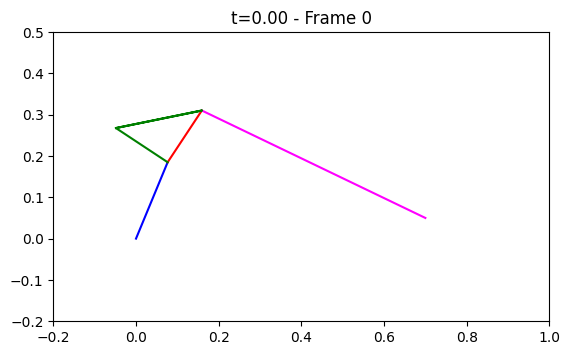

In [11]:
fig, ax = plt.subplots()

def update(i):
    ax.clear()
    plotMechanism([thetaList[i], zList[i][0], zList[i][1], xList[i]], ax)
    ax.set_title(f"t={tList[i]:.2f} - Frame {i}")

anim = animation.FuncAnimation(fig, update, frames=len(tList), repeat=False, interval=100)

# Option 1: Display as JS animation
HTML(anim.to_jshtml())
# Option 2: Display as HTML5 video (slightly heavier)
# HTML(anim.to_html5_video())


# Dinámica inversa
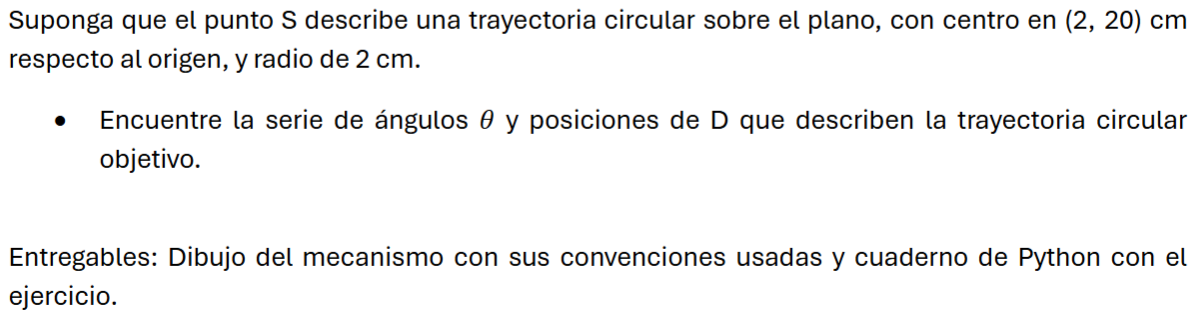

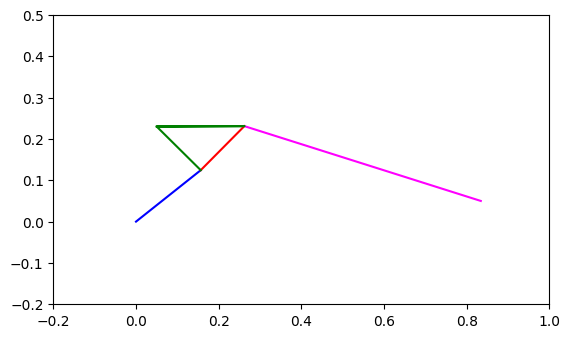

In [12]:
# Solve the vector loop equation for a known position of S.
s_star=np.array([0.05,0.23])

# Propose a value for theta1 and x and solve for theta2 and theta3

def FK(q,z0=None):
    fsolve_fun=lambda z: eq_fun(q[0],z[0],z[1],q[1])
    z0=[np.deg2rad(45),np.deg2rad(20)] if z0 is None else z0
    out=fsolve(fsolve_fun,z0,full_output=True)    
    return out[0],out

s_fun=points_fun['S']    
def IK_error(q,s_star):
    z,_=FK(q)        
    s=np.array(s_fun(q[0],z[0],z[1],q[1]))
    er=100*np.square(s-s_star).sum()    
    return er

def IK(s_star):
    q0=[np.deg2rad(64.43),0.70]
    res=minimize(lambda q: IK_error(q,s_star),q0)
    return res.x,res    

qstar,ik_out=IK(s_star)
zstar,fk_out=FK(qstar)
plotMechanism([qstar[0],zstar[0],zstar[1],qstar[1]])

In [13]:
# Do this in a loop for the defined trajectory
thetaList=np.linspace(0,np.pi*2,100)
xList=0.02+0.02*np.cos(thetaList)
yList=0.20+0.02*np.sin(thetaList)

qList=[]
for i,thetai in enumerate(thetaList):
    q,out=IK([xList[i],yList[i]])    
    qList.append(q)

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

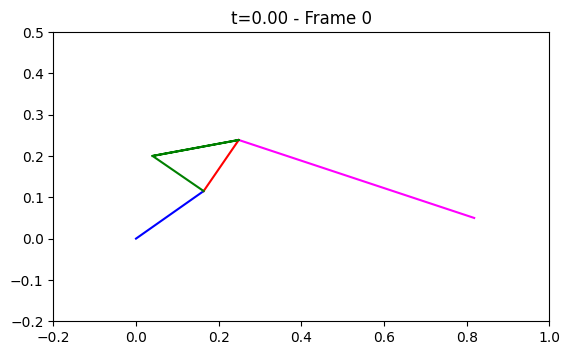

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

def update(i):
    ax.clear()  # Clear the previous frame
    z=FK(qList[i])[0]
    plotMechanism([qList[i][0], z[0], z[1], qList[i][1]],ax)
    ax.plot(xList[:i],yList[:i],'k')
    ax.set_title(f"t={tList[i]:.2f} - Frame {i}")

anim = animation.FuncAnimation(fig, update, frames=len(tList), repeat=False, interval=100)
anim.save("animation_ik.mp4", writer="ffmpeg")  # Install ffmpeg if needed
plt.show()